## Checkee.info Data Analysis
Some data analysis of the scraped data from [Checkee.info](http://checkee.info/), which is a site for people to voluntarily report the status of their VISA application cases.

The range of data scraped were from 2009 to 2018, but this analysis mainly focuses on more recent data from 2016-2018.

In [1]:
# pandas
import pandas as pd
# plotly
import plotly.offline as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# numpy
import numpy as np
# stats methods for statistical analysis
from scipy.stats import norm, normaltest, gamma
# Datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Global Parameters
MAX_CASE_LENGTH = 7 * 14  # Maximum allowed case length is 14 weeks

In [3]:
# Read data
df = pd.read_csv('VISA-Data-2018-11-30.csv')

# drop unused columns
drop_col = ['UserID', 'UserName'] + [col for col in df.columns if 'unnamed' in col.lower()]
df.drop(drop_col, axis=1, inplace=True)

# convert datatype
df['VisaType'] = pd.Categorical(df['VisaType'])
df['VisaEntry'] = pd.Categorical(df['VisaEntry'])
df['City'] = pd.Categorical(df['City'])
df['CheckDate'] = pd.Series(df['CheckDate'], dtype=np.datetime64)
df['WaitDays'] = pd.Series(df['WaitDays'], dtype=np.int8)
# derive intermediate features
df['CaseStartYear'] = pd.Series([d.year for d in df['CheckDate']])
df['CaseStartMonth'] = pd.Series([d.month for d in df['CheckDate']])
df['WaitWeeks'] = pd.Series([np.round(x/7, 1) for x in df['WaitDays']], dtype=np.float32)

## ignore absurdly long cases
# Cases that were reported to last more than 14 weeks are
# here considered outlier as they were either reported wrong 
# or rare cases that are isolated
# in addition, they tend to happen at a much lower probability
# after 2015
df.drop(df[(df['WaitDays'] > MAX_CASE_LENGTH) | (df['WaitDays'] < 0)].index, axis=0, inplace=True)

## include only recent visa data for the analysis, 2016-2018
df.drop(df[df['CaseStartYear'] < 2016].index, axis=0, inplace=True)

# show example data
df.tail()

,VisaType,VisaEntry,City,Major,VisaStatus,CheckDate,CompleteDate,WaitDays,CaseStartYear,CaseStartMonth,WaitWeeks
21810,B1,New,BeiJing,NaN,Clear,2018-11-19,2018-11-29,10,2018,11,1.4
21811,H1,New,BeiJing,Math,Clear,2018-11-20,2018-11-27,7,2018,11,1.0
21812,J1,Renewal,GuangZhou,NaN,Clear,2018-11-20,2018-11-28,8,2018,11,1.1
21813,H1,New,Montreal,CS,Clear,2018-11-21,2018-11-23,2,2018,11,0.3
21814,H1,New,GuangZhou,Computer Science,Clear,2018-11-21,2018-11-29,8,2018,11,1.1


As shown above, the raw data includs the following fields:

- **VisaType**: type of visa applied
- **VisaEntry**: is this a new application or a renewal
- **City**: city where case is processed
- **Major**: (if student visa) major of study
- **VisaStatus**: latest case status (at the date when data were scraped)
- **CheckDate**: date when case started being processed
- **CompleteDate**: date when case was finalized
- **WaitDays**: how many days waited
- **WaitWeeks**: how many weeks (round to 1 digit) waited
- **CaseStartYear**: year when case started
- **CaseStartMonth**: month when case started

Outliers, including:

1. Absurdly long cases that span longer than 14 weeks
2. Incomplete cases, including abandoned old and recent in-progress cases
3. Invalid cases, cases with the complete date earlier than the start date

are excluded in the analysis.

In [4]:
# Samples count per visa type
vt = df.groupby('VisaType')['VisaType'].count()
# Average wait days by visa type
wd = df.groupby('VisaType')['WaitDays'].mean()

## Summarize population statistics
# Pie chart - Population by Visa type
trace1 = go.Pie(
    labels=vt.index.values.tolist(), 
    values=vt.values
)
layout1 = go.Layout(
    autosize=True
)
fig1 = go.Figure(data=[trace1], layout=layout1)
py.iplot(fig1, show_link=False)

# Bar chart - Average check days by Visa type
trace2 = go.Bar(
    x=wd.index.values.tolist(),
    y=wd.values,
    width=0.6
)
layout2 = go.Layout(
    autosize=True,
    title='Average check days by Visa type',
    xaxis=dict(
        autorange=True,
        automargin=True,
        title='Visa Type'
    ),
    yaxis=dict(
        autorange=False,
        automargin=False,
        range=[7, 35],
        dtick=4,
        title='Average Check Days'
    )
)
fig2 = go.Figure(data=[trace2], layout=layout2)
py.iplot(fig2, show_link=False)

In [5]:
# Line plot - Visa type population percentage over time
popData = {
    'date': [],
    'nCase': []
}
vt = df.groupby(['CaseStartYear', 'CaseStartMonth', 'VisaType'])['CaseStartYear', 'CaseStartMonth', 'VisaType']
for vtype in df.VisaType.unique():
    popData[vtype] = []
for yr in df['CaseStartYear'].unique():
    for mo in df['CaseStartMonth'].unique():
        popData['date'].append(date(yr, mo, 1))
        sumPop = 0
        for vtype in df['VisaType'].unique():
            if (yr, mo, vtype) in vt.groups:
                popData[vtype].append(len(vt.get_group((yr, mo, vtype))))
                sumPop += len(vt.get_group((yr, mo, vtype)))
            else:
                popData[vtype].append(0)
        popData['nCase'].append(sumPop)
        # Normalize by sum
        #if sumPop:
        #    for vtype in df.VisaType.unique():
        #        popData[vtype][-1] /= sumPop / 100.0         
                
traces = []
for vtype in df['VisaType'].unique():
    traces.append(go.Scatter(
        x=popData['date'],
        y=popData[vtype],
        name=vtype
    ))  
layout = {
    'title': "Overall Visa population by type over time",
    'xaxis': {
        'range': ['2016-01-01','2018-11-01']
    }  
}
fig = dict(data=traces, layout=layout)
py.iplot(fig, show_link=False)

In [6]:
# Bar plot - F1 student check cases during peak season for application over time
f1CaseCount = []
for yr in range(2016, 2019):
    # Peak time for F1 visa application is usually from March to July
    idx = popData['date'].index(date(yr, 3, 1))
    f1CaseCount.append(sum(popData['F1'][idx:idx+4]))

trace = go.Bar(x=np.arange(2016, 2019),
                y=f1CaseCount)
layout = go.Layout(
    title='Peak time F1 check case count over time',
    xaxis=dict(
        autorange=True,
        automargin=True,
        title='Year'
    ),
    yaxis=dict(
        autorange=True,
        automargin=True,
        title='F1 check case count'
    )
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, show_link=False)

In [8]:
vt = df.groupby('VisaType')['VisaType'].count()

# Bar chart - Average check days by Visa type
trace2 = go.Bar(x=wd.index.values.tolist(),
                y=wd.values.tolist())
layout = go.Layout(
    title='Average check days by Visa type',
    xaxis=dict(
        autorange=True,
        title='Visa Type'
    ),
    yaxis=dict(
        autorange=True,
        tick0=0,
        dtick=7,
        title='Average Check Days'
    )
)
fig = go.Figure(data=[trace2], layout=layout)
py.iplot(fig, show_link=False)

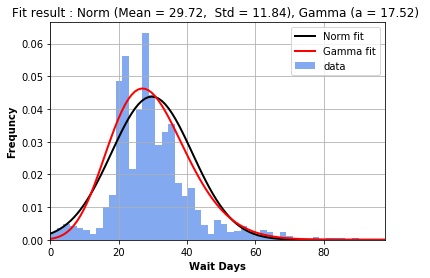

In [10]:
# Average wait days by visa type
wd = df.groupby('VisaType')['WaitDays']

# Get F1 Visa waiting days data
wdF1 = wd.get_group('F1')

# Clip irregular values (more than 14 weeks)
wdF1 = wdF1.clip_upper(MAX_CASE_LENGTH)

# Try to fit a normal distribution
mu, std = norm.fit(wdF1.values)
# and gamma distribution
a, l, s = gamma.fit(wdF1.values)

# Plot histogram overlayed with normal distribution fit
wdF1.hist(bins=50, density=True, alpha=0.8, color='#6495ED')
plt.xlabel('Wait Days',fontweight='bold')
plt.ylabel('Frequncy',fontweight='bold')
# overlay - Normal Distribution
x = np.linspace(0, MAX_CASE_LENGTH, 100)
p = norm.pdf(x, mu, std) * 1.3
plt.plot(x, p, 'k', linewidth=2)
title = "Fit result : Norm (Mean = %.2f,  Std = %.2f), Gamma (a = %.2f) " % (mu, std, a)
plt.title(title)
# overlay - Gamma Distribution
p = gamma.pdf(x, a, loc=l, scale=s) * 1.3
plt.plot(x, p, 'r', linewidth=2)

plt.legend(['Norm fit','Gamma fit','data'])
plt.tick_params(labelleft=True)
plt.xlim(0, MAX_CASE_LENGTH)
plt.show()

In [11]:
# Let's first make sure it comes from a normal distribution by conducting a Chi-squared test
_, pval = normaltest(wdF1.values)
print('Chi-Squared test p = %.10f' % pval)

# Estimate 95% confidence interval by taking [mu-1.96*SEM, mu+1.96*SEM] (assume normal distribution)
interval = norm.interval(0.95, loc=mu, scale=std/np.sqrt(wdF1.count()))
print('95%% CI of waiting days: (%.3f, %.3f)' % (interval[0], interval[1]))

Chi-Squared test p = 0.0000000000
95% CI of waiting days: (29.256, 30.174)


The plot above shows the histogram and fitted distribution based on all the F1 visa records available ($n=7992$). Here are some interpretations:
- Sample mean ($\mu=29.7$) suggest the the average waiting days for F1 visa applicant being checked is around 29.7 days. Specifically, 95% confidence interval is **(29.256, 30.174) days**
- Sample has a rather large standard deviation ($\sigma=11.84$). One standard deviation range ($\mu\pm\sigma$, *i.e.* ~68% of the population) is (17.88, 41.55) days which is about **2.5 to 6 weeks**. In addition, two standard deviation range ($\mu\pm2\sigma$, *i.e.* ~95% of the population) is (6.03, 53.40) days which is about **1 to 8.5 weeks**.
- Based on the fitted curves, a gamma (skewed distribution) looks visually better than a normal fit which implies two things. First, the mean is skewed towards the left means there are more people get cleared within 30 days (sample mean) which kinda implies a 1-month processing time. Second, distribution has a rather long tail on the right which suggest those people like me who unformatunately got checked longer than the mean **tend to be very long (e.g. I got checked for 49 days in 2017)**.